# Connect-4 with DQN 

[kaggle challenge](https://www.kaggle.com/c/connectx)

[DQN in keras youtube tutorial](https://www.youtube.com/watch?v=5fHngyN8Qhw)

[connect4 gym environment notebook](https://www.kaggle.com/alexisbcook/deep-reinforcement-learning)

In [6]:
from keras.layers import Dense,Activation
from keras.models import Sequential, load_model
from keras.optimizers import Adam
import numpy as np
from kaggle_environments import make, evaluate
from gym import spaces
import matplotlib.pyplot as plt

Loading environment football failed: No module named 'gfootball'


## replay buffer

learn from memory

In [7]:
class ReplayBuffer(object):
    def __init__(self,max_size,input_shape,n_actions,discrete=False):
        self.mem_size=max_size
        self.mem_cntr=0
        self.discrete=discrete

        self.state_memory=np.zeros((self.mem_size,input_shape))
        self.new_state_memory=np.zeros((self.mem_size,input_shape))

        dtype=np.int8 if self.discrete else np.float32
        self.action_memory = np.zeros((self.mem_size,n_actions),dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size,dtype=np.float32)

    def store_transition(self,state,action,reward,state_,done):
        # when end of memory reached, go back to begining
        index= self.mem_cntr % self.mem_size
        self.state_memory[index]=state
        self.new_state_memory[index]=state_
        self.reward_memory[index]=reward
        # done = false, when episode is over you want terminal memory to be 0 ?
        self.terminal_memory[index]= 1-int(done)
        if self.discrete:
            # one hot encoding
            actions= np.zeros(self.action_memory.shape[1])
            actions[action]=1.0
            self.action_memory[index]=actions
        else:
            self.action_memory[index]=action
        self.mem_cntr+=1

    # you want to feed batch size to network, not entire memory
    def sample_buffer(self,batch_size):
        # value to sample up to
        max_mem = min(self.mem_cntr,self.mem_size)
        # batch size = shape
        batch = np.random.choice(max_mem,batch_size)

        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        rewards = self.reward_memory[batch]
        actions = self.action_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_,terminal

## build a model

In [8]:
def build_dqn(lr,n_actions,input_dims,fcl_dims,fc2_dims,fc3_dims):
    # fcl_dims, fc2_dims are size of dense layers
    model = Sequential([
        Dense(fcl_dims,input_shape=(input_dims, )),
        Activation('relu'),
        Dense(fc2_dims),
        Activation('relu'),
        Dense(fc3_dims),
        Activation('relu'),
        Dense(n_actions)])
    model.compile(optimizer=Adam(lr=lr),loss='mse')
    return model

## agent class

- alhpa = learning rate
- gamma = discount factor for future rewards
- epsilon = random factor, sometimes take 'greedy' best known actions, sometimes take random action (explore/exploit)

In [9]:
class Agent(object): 
    
    def __init__(self,alpha,gamma,n_actions,epsilon, batch_size,input_dims,epsilon_dec=0.996,epsilon_end=0.01,mem_size=1000000,fname='dqn_model.h5'):
        self.action_space=[i for i in range(n_actions)]
        self.gamma=gamma
        self.epsilon=epsilon
        self.epsilon_dec=epsilon_dec
        self.epsilon_min = epsilon_end
        self.batch_size=batch_size
        self.model_file=fname

        self.memory=ReplayBuffer(mem_size,input_dims,n_actions,discrete=True)
        self.q_eval=build_dqn(alpha,n_actions,input_dims,256,256,128)

    def remember(self,state,action,reward,new_state,done):
        self.memory.store_transition(state,action,reward,new_state,done)

    def choose_action(self,state):
        state = state[np.newaxis,:]
        rand = np.random.random()
        if rand<self.epsilon:
            # random action
            action = np.random.choice(self.action_space)
        else:
            # best action
            actions=self.q_eval.predict(state)
            action = np.argmax(actions)
        return action
    def learn(self):
        # temporal difference learning = learn on every step
        # fill up batch size before starting to learn
        if self.memory.mem_cntr < self.batch_size:
            return 
        
        # non sequential sampling, dont get hung up
        state,action,reward,new_state,done=\
            self.memory.sample_buffer(self.batch_size)

        # one hot back to integer
        action_values = np.array(self.action_space,dtype=np.int8)
        action_indices = np.dot(action,action_values)

        ## predict next states
        q_eval = self.q_eval.predict(state)
        q_next = self.q_eval.predict(new_state)

        q_target = q_eval.copy()

        batch_index = np.arange(self.batch_size,dtype=np.int32)

        q_target[batch_index,action_indices] = reward + \
            self.gamma*np.max(q_next,axis=1)*done
        
        # learning operation, q_target is what we are shooting for 
        # (best possible action)
        _ = self.q_eval.fit(state,q_target,verbose=0)

        self.epsilon = self.epsilon*self.epsilon_dec if \
            self.epsilon>self.epsilon_min else self.epsilon_min
    def save_model(self):
        self.q_eval.save(self.model_file)

    def load_model(self):
        self.q_eval=load_model(self.model_file)

## create environment

The connectx kaggle environment interacts with a python function that accepts 2 arguments obs & config and returns ant integer between 0-6 (column)

obs
- obs.board = python list for each item of grid
- obs.mark = the piece assigned to the agent 1/2

config 
- config.rows = number of rows in a game = 6
- config.columns = number of columns in a game = 7
- config.inarow = how many pieces to get in a row = 4


In [10]:
class ConnectFourGym:
    def __init__(self, agent2="random"):
        ks_env = make("connectx", debug=True)
        self.env = ks_env.train([None, agent2])
        self.rows = ks_env.configuration.rows
        self.columns = ks_env.configuration.columns
        self.action_space = spaces.Discrete(self.columns)
        self.observation_space = spaces.Box(low=0, high=2, 
                                            shape=(self.rows,self.columns,1), dtype=np.int)
        # Tuple corresponding to the min and max possible rewards
        self.reward_range = (-10, 1)
        # StableBaselines throws error if these are not defined
        self.spec = None
        self.metadata = None
    def reset(self):
        self.obs = self.env.reset()
        return np.array(self.obs['board'])
    def change_reward(self, old_reward, done):
        if old_reward == 1: # The agent won the game
            return 1
        elif done: # The opponent won the game
            return -1
        else: # Reward 1/42
            return 1/(self.rows*self.columns)
    def step(self, action):
        # Check if agent's move is valid
        is_valid = (self.obs['board'][int(action)] == 0)
        if is_valid: # Play the move
            self.obs, old_reward, done, _ = self.env.step(int(action))
            reward = self.change_reward(old_reward, done)
        else: # End the game and penalize agent
            reward, done, _ = -10, True, {}
        return np.array(self.obs['board']), reward, done, _

        # np.array(self.obs['board']).reshape(self.rows,self.columns,1)

## training function

In [11]:
def train(agent,n_games):
    for i in range(n_games):
        done=False
        score=0
        observation=env.reset()
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            score+=reward
            agent.remember(observation,action,reward,observation_,done)
            observation = observation_
            agent.learn()
        eps_history.append(agent.epsilon)
        scores.append(score)

        # save model every 10 games
        if i%10 == 0 and i>0:
            agent.save_model()
            # show average score of last 100 games
            avg_score = np.mean(scores[max(0,i-100):(i+1)])
            print(f'episode {i} score {round(score,2)}, average score {round(avg_score,2)}')
            avg_history.append(avg_score)
        

## play games / training

300 times against random opponent

300 times against agent that trained 300 times with random

### Agent1: train with random opponent

In [1]:
env = ConnectFourGym(agent2="random")
n_games=50
agent= Agent(gamma=0.99,epsilon=1.0,alpha=0.0005,input_dims=42, n_actions=7,mem_size=1000000,batch_size=64,epsilon_end=0.01,fname='agent1.h5')
scores=[]
eps_history=[]
avg_history=[]
train(agent,n_games)

NameError: name 'ConnectFourGym' is not defined

In [ ]:
plt.plot(range(len(scores)),scores)
plt.plot(range(len(eps_history)),eps_history)
plt.ylim(-2,2)

In [ ]:
plt.plot(range(len(avg_history)),avg_history)
plt.ylim(-2,2)

### Agent2: train with agent1

In [ ]:
model1= Agent(gamma=0.99,epsilon=0,alpha=0.0005,input_dims=42, n_actions=7,mem_size=1000000,batch_size=64,epsilon_end=0.01,fname='agent1.h5')
model1.load_model()
def agent1(obs,config):
    return int(model1.choose_action(np.array(obs['board'])))

In [ ]:
env = ConnectFourGym(agent2=agent1)
n_games = 300
agent = Agent(gamma=0.99,epsilon=1.0,alpha=0.0005,input_dims=42, n_actions=7,mem_size=1000000,batch_size=64,epsilon_end=0.01,
fname='agent2.h5')
scores=[]
eps_history=[]
avg_history=[]
train(agent,n_games)

In [ ]:
plt.plot(range(len(scores)),scores)
plt.plot(range(len(eps_history)),eps_history)
plt.ylim(-2,2)

In [ ]:
plt.plot(range(len(avg_history)),avg_history)
plt.ylim(-2,2)

### Agent3: train with agent2

In [48]:
model2 = Agent(gamma=0.99,epsilon=0,alpha=0.0005,input_dims=42, n_actions=7,mem_size=1000000,batch_size=64,epsilon_end=0.01,
fname='agent2.h5')
model2.load_model()
def agent2(obs,config):
    action = int(model2.choose_action(np.array(obs['board'])))
    valid=[col for col in range(config.columns) if obs.board[col]==0]
    if action in valid:
        return action
    return valid[0]

In [23]:
env = ConnectFourGym(agent2=agent2)
n_games = 300
agent = Agent(gamma=0.99,epsilon=1.0,alpha=0.0005,input_dims=42, n_actions=7,mem_size=1000000,batch_size=64,epsilon_end=0.01,
fname='agent3.h5')
scores=[]
eps_history=[]
avg_history=[]
train(agent,n_games)

episode 10 score -0.83, average score -0.92
episode 20 score -0.86, average score -1.03
episode 30 score -0.81, average score -2.06
episode 40 score -0.83, average score -2.05
episode 50 score 1.26, average score -1.73
episode 60 score 1.19, average score -1.71
episode 70 score 1.17, average score -1.44
episode 80 score 1.07, average score -1.35
episode 90 score 1.14, average score -1.16
episode 100 score 1.26, average score -1.05
episode 110 score 1.19, average score -0.93
episode 120 score 1.17, average score -0.74
episode 130 score -0.88, average score -0.44
episode 140 score -0.86, average score -0.16
Invalid Action: Invalid column: 1
episode 150 score -0.71, average score -0.08
episode 160 score 1.07, average score 0.14
episode 170 score 1.21, average score 0.21
episode 180 score 1.29, average score 0.31
episode 190 score 1.12, average score 0.38
episode 200 score -0.76, average score 0.4
episode 210 score 1.14, average score 0.5
episode 220 score 1.29, average score 0.5
episode 2

(-2.0, 2.0)

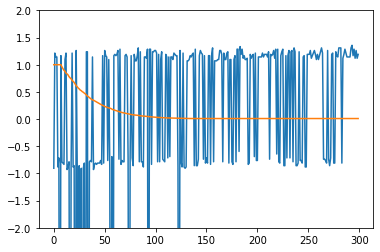

In [24]:
plt.plot(range(len(scores)),scores)
plt.plot(range(len(eps_history)),eps_history)
plt.ylim(-2,2)

(-3.0, 1.0)

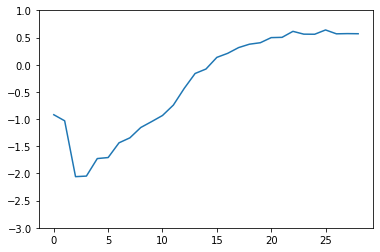

In [27]:
plt.plot(range(len(avg_history)),avg_history)
plt.ylim(-3,1)

### Agent4: train with negamax

In [55]:
env = ConnectFourGym(agent2='negamax')
n_games = 1000
agent = Agent(gamma=0.99,epsilon=1.0,alpha=0.0005,epsilon_dec=0.999,input_dims=42, n_actions=7,mem_size=1000000,batch_size=64,epsilon_end=0.01,
fname='agent4.h5')
scores=[]
eps_history=[]
avg_history=[]
train(agent,n_games)

episode 10 score -0.76, average score -2.47
episode 20 score -0.74, average score -1.7
episode 30 score -0.93, average score -2.29
episode 40 score -9.67, average score -2.31
episode 50 score -0.93, average score -2.02
episode 60 score -0.83, average score -2.12
episode 70 score -0.81, average score -2.2
episode 80 score -9.69, average score -2.57
episode 90 score -0.83, average score -2.67
episode 100 score -0.71, average score -2.49
episode 110 score -0.76, average score -2.57
episode 120 score -0.76, average score -2.66
episode 130 score -0.67, average score -2.57
episode 140 score -0.86, average score -2.85
episode 150 score -0.83, average score -2.94
episode 160 score -0.71, average score -2.82
episode 170 score -0.93, average score -2.73
episode 180 score -0.88, average score -2.35
episode 190 score -0.74, average score -2.17
episode 200 score -0.76, average score -2.25
episode 210 score -0.88, average score -1.99
episode 220 score -0.71, average score -1.89
episode 230 score -0.

(-2.0, 2.0)

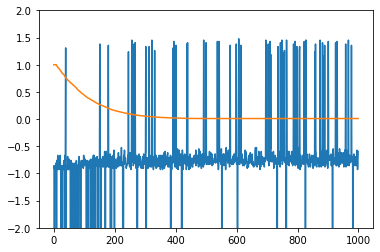

In [56]:
plt.plot(range(len(scores)),scores)
plt.plot(range(len(eps_history)),eps_history)
plt.ylim(-2,2)

(-3.0, 1.0)

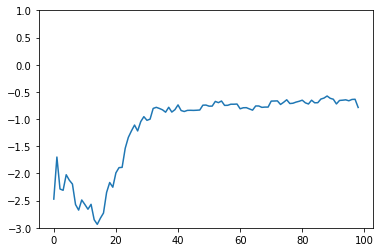

In [57]:
plt.plot(range(len(avg_history)),avg_history)
plt.ylim(-3,1)

### Agent5: train with agent4

In [74]:
env = ConnectFourGym(agent2=agent4)
n_games = 500
agent = Agent(gamma=0.99,epsilon=1.0,alpha=0.0005,epsilon_dec=0.998,input_dims=42, n_actions=7,mem_size=1000000,batch_size=64,epsilon_end=0.01,
fname='agent5.h5')
scores=[]
eps_history=[]
avg_history=[]
train(agent,n_games)

episode 10 score -0.81, average score -1.05
episode 20 score 1.14, average score -1.18
episode 30 score 1.19, average score -0.81
episode 40 score -9.74, average score -0.93
episode 50 score 1.19, average score -0.89
episode 60 score 1.12, average score -0.89
episode 70 score 1.24, average score -0.68
episode 80 score 1.07, average score -0.5
episode 90 score 1.19, average score -0.38
episode 100 score 1.17, average score -0.5
episode 110 score -0.74, average score -0.36
episode 120 score 1.21, average score -0.17
episode 130 score 1.21, average score -0.14
episode 140 score 1.26, average score -0.04
episode 150 score -0.83, average score 0.22
episode 160 score -0.81, average score 0.33
episode 170 score -0.71, average score 0.31
episode 180 score 1.19, average score 0.27
episode 190 score 1.36, average score 0.25
episode 200 score 1.19, average score 0.44
episode 210 score -0.83, average score 0.39
episode 220 score 1.19, average score 0.43
episode 230 score -0.83, average score 0.47


(-2.0, 2.0)

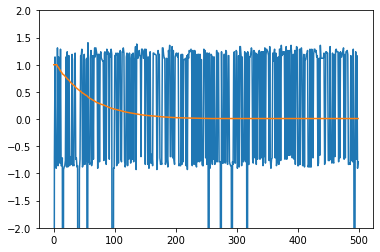

In [75]:
plt.plot(range(len(scores)),scores)
plt.plot(range(len(eps_history)),eps_history)
plt.ylim(-2,2)

(-3.0, 1.0)

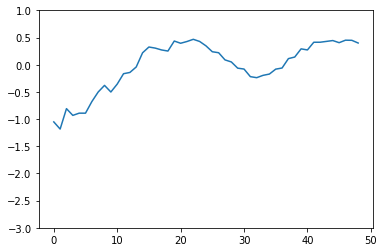

In [76]:
plt.plot(range(len(avg_history)),avg_history)
plt.ylim(-3,1)

### Agent6: try bigger model

In [102]:
env = ConnectFourGym(agent2='random')
n_games = 1000
agent = Agent(gamma=0.99,epsilon=1.0,alpha=0.0005,epsilon_dec=0.999,input_dims=42, n_actions=7,mem_size=1000000,batch_size=64,epsilon_end=0.01,
fname='agent6.h5')
scores=[]
eps_history=[]
avg_history=[]
train(agent,n_games)

episode 10 score -0.81, average score -2.5
episode 20 score -9.81, average score -2.68
episode 30 score -9.71, average score -2.86
episode 40 score 1.38, average score -2.55
episode 50 score 1.21, average score -2.18
episode 60 score 1.24, average score -2.11
episode 70 score 1.26, average score -2.2
episode 80 score -0.86, average score -1.9
episode 90 score -0.81, average score -1.65
episode 100 score 1.26, average score -1.57
episode 110 score -0.86, average score -1.31
episode 120 score 1.21, average score -1.16
episode 130 score -0.9, average score -1.03
episode 140 score -9.71, average score -0.9
episode 150 score 1.12, average score -0.84
episode 160 score -0.76, average score -0.77
episode 170 score 1.19, average score -0.51
episode 180 score 1.21, average score -0.62
episode 190 score -0.86, average score -0.75
episode 200 score -0.74, average score -0.76
episode 210 score 1.17, average score -0.74
episode 220 score 1.26, average score -0.72
episode 230 score 1.33, average sco

(-2.0, 2.0)

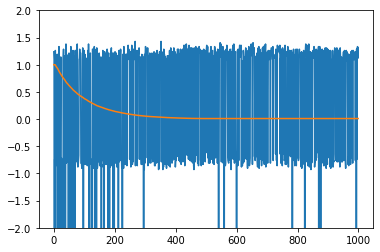

In [103]:
plt.plot(range(len(scores)),scores)
plt.plot(range(len(eps_history)),eps_history)
plt.ylim(-2,2)

(-3.0, 1.0)

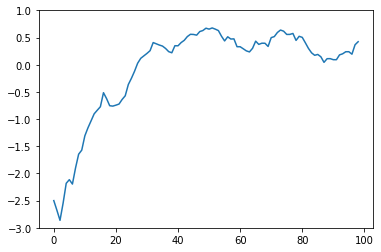

In [104]:
plt.plot(range(len(avg_history)),avg_history)
plt.ylim(-3,1)

## test agent

In [12]:
env = make("connectx", debug=True)

In [59]:
model3 = Agent(gamma=0.99,epsilon=0.01,alpha=0.0005,input_dims=42, n_actions=7,mem_size=1000000,batch_size=64,epsilon_end=0.01,
fname='agent3.h5')
model3.load_model()
def agent3(obs,config):
    action = int(model3.choose_action(np.array(obs['board'])))
    valid=[col for col in range(config.columns) if obs.board[col]==0]
    if action in valid:
        return action
    return valid[0]

In [60]:
model4 = Agent(gamma=0.99,epsilon=0.01,alpha=0.0005,input_dims=42, n_actions=7,mem_size=1000000,batch_size=64,epsilon_end=0.01,
fname='agent4.h5')
model4.load_model()
def agent4(obs,config):
    action = int(model4.choose_action(np.array(obs['board'])))
    valid=[col for col in range(config.columns) if obs.board[col]==0]
    if action in valid:
        return action
    return valid[0]

In [77]:
model5 = Agent(gamma=0.99,epsilon=0.01,alpha=0.0005,input_dims=42, n_actions=7,mem_size=1000000,batch_size=64,epsilon_end=0.01,
fname='agent5.h5')
model5.load_model()
def agent5(obs,config):
    action = int(model4.choose_action(np.array(obs['board'])))
    valid=[col for col in range(config.columns) if obs.board[col]==0]
    if action in valid:
        return action
    return valid[0]

In [13]:
model6 = Agent(gamma=0.99,epsilon=0.01,alpha=0.0005,input_dims=42, n_actions=7,mem_size=1000000,batch_size=64,epsilon_end=0.01,
fname='agent6.h5')
model6.load_model()
def agent6(obs,config):
    action = int(model4.choose_action(np.array(obs['board'])))
    valid=[col for col in range(config.columns) if obs.board[col]==0]
    if action in valid:
        return action
    return valid[0]

### create agent from stored model

In [15]:
model6 = load_model('agent6.h5')
def agent6(obs,config):
    actions=model6.predict(np.array(obs['board'])[np.newaxis,:])
    action = int(np.argmax(actions))

    valid=[col for col in range(config.columns) if obs.board[col]==0]
    if action in valid:
        return action
    return valid[0]


In [16]:
env.run(['random',agent6])

# Show the game
env.render(mode="ipython")

In [61]:
def get_win_percentages(agent1, agent2, n_rounds=100):
    # Use default Connect Four setup
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    # Agent 1 goes first (roughly) half the time          
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    # Agent 2 goes first (roughly) half the time      
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))

In [62]:
get_win_percentages(agent1=agent1, agent2=agent4)

Agent 1 Win Percentage: 0.0
Agent 2 Win Percentage: 1.0
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


In [107]:
get_win_percentages(agent1=agent3, agent2=agent6)

Agent 1 Win Percentage: 0.5
Agent 2 Win Percentage: 0.5
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


In [108]:
get_win_percentages(agent1=agent4, agent2=agent6)

Agent 1 Win Percentage: 0.5
Agent 2 Win Percentage: 0.5
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


In [106]:
get_win_percentages(agent1=agent5, agent2=agent6)

Agent 1 Win Percentage: 0.5
Agent 2 Win Percentage: 0.5
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


In [109]:
get_win_percentages(agent1='random', agent2=agent6)

Agent 1 Win Percentage: 0.35
Agent 2 Win Percentage: 0.65
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


In [110]:
get_win_percentages(agent1="negamax", agent2=agent6)

Agent 1 Win Percentage: 0.91
Agent 2 Win Percentage: 0.09
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


## play yourself against agent

In [17]:
env = make("connectx", debug=True)
from IPython.display import clear_output

def agent_me(obs,config):
    env.render(mode="ipython")
    turn = input("Enter turn (0-6):")
    clear_output()
    return int(turn)

In [18]:
env.run([agent6,agent_me])
env.render(mode="ipython")

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/kaggle_environments/agent.py", line 151, in act
    action = self.agent(*args)
  File "<ipython-input-17-66683dbf1253>", line 8, in agent_me
    return int(turn)
ValueError: invalid literal for int() with base 10: ''
Error: ['Traceback (most recent call last):\n', '  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/kaggle_environments/agent.py", line 151, in act\n    action = self.agent(*args)\n', '  File "<ipython-input-17-66683dbf1253>", line 8, in agent_me\n    return int(turn)\n', "ValueError: invalid literal for int() with base 10: ''\n"]
